In [29]:
import sys
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel
import pandas as pd

In [30]:
training_folder = '../../'
plot_path = training_folder + 'outputs/plot/'

In [31]:
sm = stepmodel.read_zip(training_folder + r'model/preparation/walk_model.zip')

read_hdf: 100%|████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 15.16it/s]


# ROUTE BREAKER: rail submodel

In [32]:
# add required fields
sm.links['length'] = sm.links['road_length']

In [33]:
rail = sm.copy()
rail.links = rail.links.loc[rail.links['route_type'].isin(['tram', 'subway', 'rail'])] 

In [34]:
rail.step_pt_pathfinder(
    broken_routes=True,
    broken_modes=False,
    route_column='route_short_name',
    mode_column='route_type',
    speedup=True
)

path_analysis: 100%|██████████████████████████████████████████████████████████| 29573/29573 [00:00<00:00, 35289.73it/s]


In [35]:
rail.pt_los.set_index(['origin', 'destination'])['pathfinder_session'].value_counts()

route_breaker    17473
best_path        12100
Name: pathfinder_session, dtype: int64

# MODE BREAKER

In [36]:
sm.links.drop(['index'], axis=1,inplace=True, errors='ignore')
sm.step_pt_pathfinder(
    broken_routes=False,
    broken_modes=True,
    route_column='route_short_name'
)

path_analysis: 100%|██████████████████████████████████████████████████████████| 65683/65683 [00:01<00:00, 35971.18it/s]


# CONCATENATION

In [37]:
both = sm.copy()

In [38]:
both.pt_los = pd.concat(
    [sm.pt_los, rail.pt_los]
).drop_duplicates(subset=['path'])

In [39]:
both.pt_los.set_index(['origin', 'destination'])['pathfinder_session'].value_counts()

mode_breaker     65683
route_breaker    13224
Name: pathfinder_session, dtype: int64

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:17<00:00,  2.17s/it]


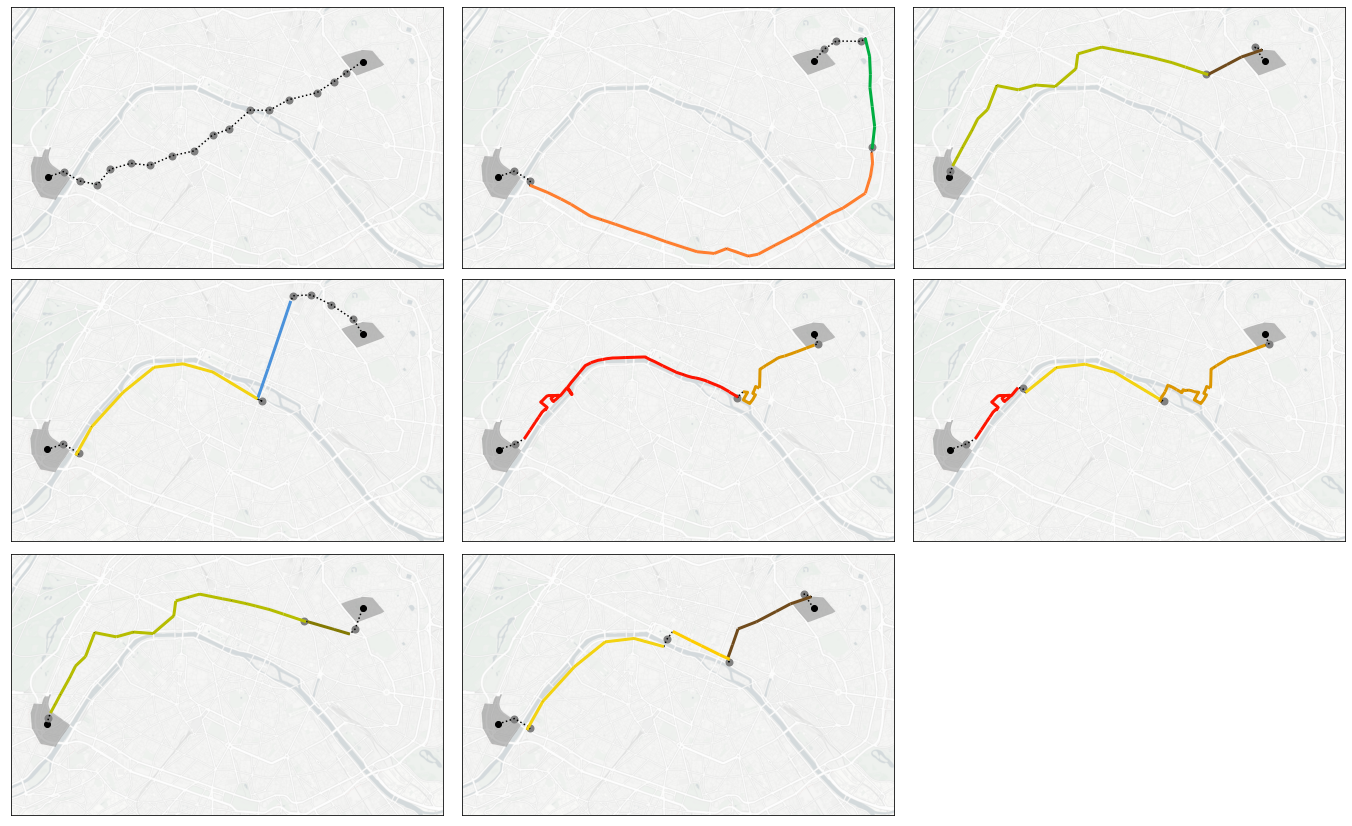

In [40]:
both.links['color'] = '#' + both.links['route_color']
origin, destination='zone_74',  'zone_105'
rows = 3
fig, axes = both.plot_separated_paths(
    origin, destination, rows=rows, figsize=[20, 20],
    title=None, constrained_layout=True, zoom=13, resize=True,
    basemap_url='http://a.basemaps.cartocdn.com/light_nolabels/tileZ/tileX/tileY.png', 
)

In [41]:
both.to_zip(training_folder + 'model/base/pruning_pt_pathfinder.zip')

to_hdf(new file): 100%|████████████████████████████████████████████████████████████████| 37/37 [00:04<00:00,  8.34it/s]


# END